In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc as py
import arviz as az

In [2]:
gameweek = pd.read_csv('/Users/nduqwele/Code/GithubProjects/Fantasy-Premier-League/data/2021-22/gws/merged_gw.csv')
pd.set_option("display.max_columns",None)
sns.set_theme() # To apply basic seaborn theme

In [9]:
# let have a look at a few explanitory variables that we can use.
gameweek.head()


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Eric Bailly,DEF,Man Utd,0.0,0,0,0,0,0.0,286,6,0,0,0.0,0.0,2021-08-14T11:30:00Z,0,10,0,0,0,0,1,0,9363,1,5,0.0,0,0,0,0,50,True,0,1
1,Keinan Davis,FWD,Aston Villa,0.4,0,0,0,0,0.0,49,8,0,0,0.0,0.0,2021-08-14T14:00:00Z,0,18,0,0,0,0,1,0,169789,2,3,0.0,0,0,0,0,45,False,0,1
2,Ayotomiwa Dele-Bashiru,MID,Watford,0.0,0,0,0,0,0.0,394,8,0,0,0.0,0.0,2021-08-14T14:00:00Z,0,2,0,0,0,0,1,0,4092,2,3,0.0,0,0,0,0,45,True,0,1
3,James Ward-Prowse,MID,Southampton,2.3,0,0,20,0,30.5,341,4,3,0,5.2,21.6,2021-08-14T14:00:00Z,90,8,0,0,0,0,1,0,299682,1,3,0.0,2,0,0,0,65,False,0,1
4,Bruno Miguel Borges Fernandes,MID,Man Utd,4.4,0,3,61,0,35.9,277,6,1,3,20.1,106.2,2021-08-14T11:30:00Z,90,10,0,0,0,0,1,0,3381004,1,5,59.0,20,0,0,0,120,True,0,1


In [55]:

T1 = gameweek[['GW','name','total_points', 'value','transfers_out','transfers_in']]
explain =T1[['value','transfers_out','transfers_in']]
explain = explain[T1['GW'] == 5]
free = T1[['total_points']]
free = free[T1['GW'] == 5]

# what are the conditions that 
print((free.max()),free.min()) 

# then suspect that our model if crashing becuase of values being negativ


total_points    15
dtype: int64 total_points   -1
dtype: int64


In [57]:
explain_std = explain.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(2))
explain_std

free['total_points_1'] = np.where(free['total_points']<0,0,free['total_points']) # we are fixing a domain issue here.
free

,total_points,total_points_1
2296,0,0
2297,0,0
2298,0,0
2299,3,3
2300,2,2
...,...,...
2897,1,1
2898,1,1
2899,3,3
2900,0,0


In [58]:
# lets bring in our p

with py.Model() as TP_count:

    #define priors as weekly 
    b0 = py.Normal("intercept", mu=0, sigma=10)
    b1 = py.Normal("value", mu= 0,sigma=10)
    b2 = py.Normal("transfers_out", mu= 0,sigma=10)
    b3 = py.Normal("transfers_in", mu= 0,sigma=10)

    # our linear model 
    # theta = b0 +b1 * T1['value'] + b2 *T1['transfers_out'] + b3 *T1['transfers_in']
    theta = b0 +b1 * explain_std['value'].values + b2 *explain_std['transfers_out'].values + b3 *explain_std['transfers_in'].values    
    # define poisson likelihood
    y = py.Poisson("y", mu=py.math.exp(theta), observed = free["total_points_1"].values)



In [62]:
# carefull next time just make sure your target y is tractable
with TP_count:
    total_points = py.sample(1000, tune=1000,cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, value, transfers_out, transfers_in]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 2296 to 2901
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   value          606 non-null    float64
 1   transfers_out  606 non-null    float64
 2   transfers_in   606 non-null    float64
dtypes: float64(3)
memory usage: 18.9 KB


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'value'}>],
       [<AxesSubplot:title={'center':'transfers_out'}>,
        <AxesSubplot:title={'center':'transfers_out'}>],
       [<AxesSubplot:title={'center':'transfers_in'}>,
        <AxesSubplot:title={'center':'transfers_in'}>]], dtype=object)

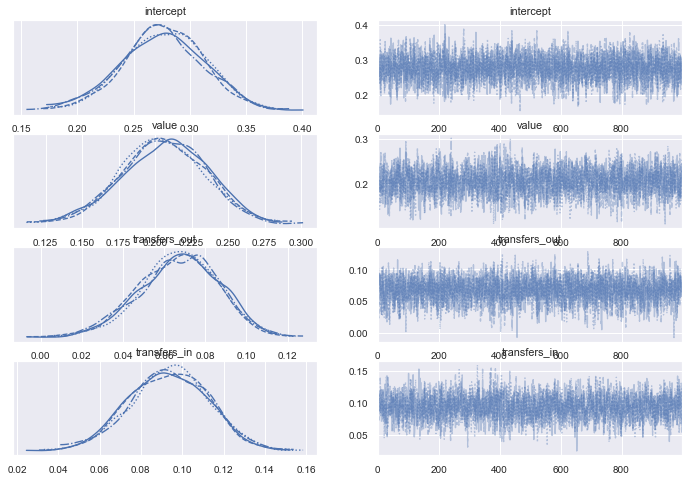

In [63]:

az.plot_trace(total_points)

In [65]:
az.summary(np.exp(total_points.posterior), kind= "stats")

,mean,sd,hdi_3%,hdi_97%
intercept,1.319,0.048,1.232,1.411
value,1.229,0.035,1.161,1.294
transfers_out,1.070,0.021,1.032,1.108
transfers_in,1.098,0.021,1.060,1.138


In [72]:
# i want to select distinct values in column
gameweek['total_points'].unique()
gameweek['total_points'].value_counts()

 0     14908
 1      3297
 2      2872
 3       779
 6       778
 5       356
 7       323
 8       269
 4       208
 9       208
 10      114
 11       83
 12       78
-1        71
 13       61
 15       41
 14       40
-2        24
 16       14
 18       10
-3         9
 17        7
 24        4
 19        4
 20        3
-4         2
 21        2
Name: total_points, dtype: int64

<AxesSubplot:xlabel='total_points', ylabel='Count'>

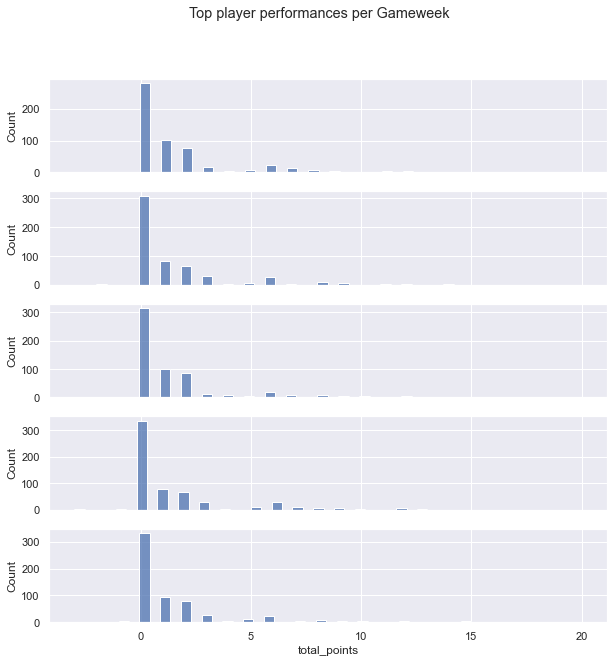

In [78]:


# sns.histplot(data=gameweek, x='total_points')
sns.set(rc={'figure.figsize':(10,10)})
fig, ax = plt.subplots(5,1, sharex=True) # we add dimensions here of how the plots should look like.
sns.color_palette("rocket")
# we can share x and y axis, nice :)!
fig.suptitle("Top player performances per Gameweek")
# remember there is some additional axis chagnes we need in the data to make sure we are gucci.

#goalkeepeers
# sns.barplot(ax=ax[0], x="GW",y="total_points",data=DF_bestplayers[DF_bestplayers["position"]=='DEF'])
# ax[0].set_title("Goalkeepers")

sns.histplot(ax=ax[0],data=gameweek[gameweek['GW']==1], x='total_points')

sns.histplot(ax=ax[1],data=gameweek[gameweek['GW']==2], x='total_points')
sns.histplot(ax=ax[2],data=gameweek[gameweek['GW']==3], x='total_points')
sns.histplot(ax=ax[3],data=gameweek[gameweek['GW']==4], x='total_points')
sns.histplot(ax=ax[4],data=gameweek[gameweek['GW']==5], x='total_points')